<a href="https://colab.research.google.com/github/dyjdlopez/demo-hybrid-quantum-nn/blob/main/demo_hqn_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hybrid Quantum Neural Networks Part 2: Quantum-ready Training with Parameter-shift Rule

In [1]:
!pip install nvidia-cusparse-cu12 nvidia-cublas-cu12 nvidia-cuda-runtime-cu12 custatevec_cu12
!pip install pennylane pennylane-lightning-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 9.9 MB/s eta 0:00:00
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl (21.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.2.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64",

In [46]:
import pennylane as qml

from torch.autograd import Function
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from pennylane import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

torch.manual_seed(42)
np.random.seed(42)

## 1. Importing the Data (MNIST)

In [47]:
# Training set.
sample_count = 140



X_train = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)

# Leaving only labels 0 and 1.
idx = np.append(
    np.where(X_train.targets == 0)[0][:sample_count],
    np.where(X_train.targets == 1)[0][:sample_count],
)

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

# Test set.
sample_count = 70

X_test = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)
idx = np.append(
    np.where(X_test.targets == 0)[0][:sample_count],
    np.where(X_test.targets == 1)[0][:sample_count],
)

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

## 2. Defining the Quantum Layer

In [48]:
device = "cuda"
BATCH_SIZE = 1

In [49]:
n_qubits = 1
dev = qml.device("lightning.gpu", wires=n_qubits)


@qml.qnode(dev)
def circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [50]:
n_layers = 1
weight_shapes = {"weights": (n_layers, n_qubits)}

qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)

In [51]:
class QuantumFunction(Function):
    """Allows the quantum circuit to pass data through it and compute the gradients"""

    @staticmethod
    def forward(ctx, thetas: torch.tensor, quantum_circuit,
                shift) -> torch.tensor:
        # Save shift and quantum_circuit in context to use in backward
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        expectation_z = ctx.quantum_circuit.forward(thetas)

        ctx.save_for_backward(thetas, expectation_z)

        return expectation_z

    @staticmethod
    def backward(ctx, grad_output):
        """Backward pass computation via finite difference parameter shift"""

        thetas, expectation_z = ctx.saved_tensors

        gradients = torch.zeros((BATCH_SIZE,thetas.size()[1],2))

        for i in range(thetas.size()[1]):
            shift_right = torch.clone(thetas)

            shift_right[:,i] += ctx.shift

            shift_left = torch.clone(thetas)
            shift_left[:,i] -= ctx.shift

            expectation_right = ctx.quantum_circuit(shift_right).to(device)
            expectation_left = ctx.quantum_circuit(shift_left).to(device)
            gradients[:,i,:] = 0.5 * (expectation_right - expectation_left) * grad_output.float().to(device)

        grads = torch.sum(gradients, axis =2).cuda()


        return grads, None, None

In [52]:
class QuantumLayer(nn.Module):
    """Encapsulates a quantum circuit and a quantum function into a quantum layer"""

    def __init__(self, shift: torch.tensor):
        super(QuantumLayer, self).__init__()
        self.quantum_circuit = qlayer
        self.shift = shift

    def forward(self, inputs):
        ans = QuantumFunction.apply(inputs, self.quantum_circuit, self.shift)

        return ans

In [53]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # Neural network structure.
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(
            64, 1)
        self.qfc1 = QuantumLayer(torch.tensor(np.pi / 2))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.qfc1(x).reshape(-1)

        return torch.cat((x, 1 - x), -1).unsqueeze(0)

In [54]:
# We move our model to the CUDA device to minimise data transfer between GPU and CPU.

model = Net().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_func = nn.NLLLoss().to(device)

epochs = 20

epoch_loss = []

model.train()
for epoch in tqdm(range(epochs)):
    batch_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):  # Batch training.
        optimizer.zero_grad()

        data, target = data.to(device), target.to(device)

        # Forward pass.
        output = model(data).to(device)


        # Calculating loss.
        loss = loss_func(output, target).to(device)

        # Backward pass.
        loss.backward()

        # Optimize the weights.
        optimizer.step()

        batch_loss += loss.item()

    epoch_loss.append(batch_loss / batch_idx)

    print("Training [{:.0f}%]\tLoss: {:.4f}".format(
        100.0 * (epoch + 1) / epochs, epoch_loss[-1]))

  0%|          | 0/20 [00:00<?, ?it/s]

Training [5%]	Loss: -0.5253
Training [10%]	Loss: -0.6029
Training [15%]	Loss: -0.6220
Training [20%]	Loss: -0.6252
Training [25%]	Loss: -0.6255
Training [30%]	Loss: -0.6280
Training [35%]	Loss: -0.6292
Training [40%]	Loss: -0.6293
Training [45%]	Loss: -0.6306
Training [50%]	Loss: -0.6321
Training [55%]	Loss: -0.6307
Training [60%]	Loss: -0.6301
Training [65%]	Loss: -0.6322
Training [70%]	Loss: -0.6324
Training [75%]	Loss: -0.6317
Training [80%]	Loss: -0.6326
Training [85%]	Loss: -0.6315
Training [90%]	Loss: -0.6305
Training [95%]	Loss: -0.6321
Training [100%]	Loss: -0.6327


Text(0, 0.5, 'Neg Log Likelihood Loss')

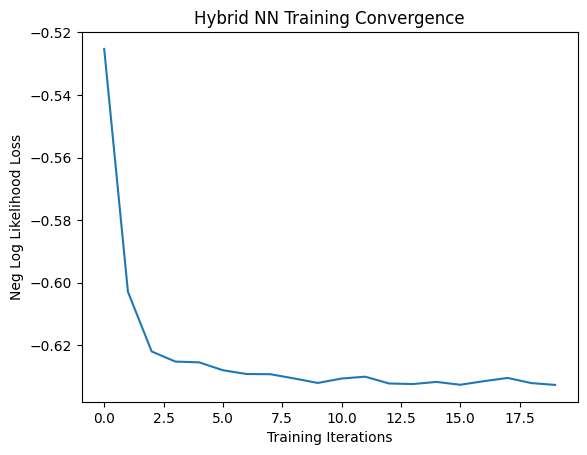

In [55]:
plt.plot(epoch_loss)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")

plt.ylabel("Neg Log Likelihood Loss")

In [56]:
# Testing on the test set.

model.eval()
with torch.no_grad():
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)

        output = model(data).to(device)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        epoch_loss.append(loss.item())

    print("Performance on test data:\n\tAccuracy: {:.1f}%".format(
        correct / len(test_loader) * 100))

Performance on test data:
	Accuracy: 50.0%
